In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


##### Set the path to directory containing code of this case

In [2]:
new_path = 'C:\\Users\\Windows\\Documents\\LTrace\\GeoModeling_GANSim-2D_Condition_to_Well_Facies_and_Global_Features\\Code\\1_conditioning_to_well_facies_alone_or_with_global_features\\'
sys.path.append(new_path)

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [3]:
data_dir_test = 'C:\\Users\\Windows\\Documents\\LTrace\\GeoModeling_GANSim-2D_Condition_to_Well_Facies_and_Global_Features\\TrainingData\\'

#### Set path to trained network

In [4]:
# 19200 means totally 19200 thousand training images (facies models) used for the training
network_dir = 'C:\\Users\\Windows\\Documents\\LTrace\\GeoModeling_GANSim-2D_Condition_to_Well_Facies_and_Global_Features\\TrainingResults\\3_GANs conditioned to mud proportion gf and well facies\\103-pgan-cond-Well-mudprop-2gpu\\'
network_name = 'network-snapshot-017920.pkl'

### 1. Fetch dataset

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset
# tfrecord_dir='TestData' to fetch test dataset, if tfrecord_dir='TrainingData' to fetch training dataset
# labeltypes: 0 for 'channelorientation', 1 for 'mudproportion', 2 for 'channelwidth', 3 for 'channelsinuosity'
# well_enlarge: if True, well points occupy 4x4 area, otherwise occupy 1x1 area
test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', labeltypes = [1,2,3], well_enlarge = True, shuffle_mb = 0, prefetch_mb = 0)

# labels are from -1 to 1
image_test, label_test = test_set.get_minibatch_imageandlabel_np(3000)  
probimg_test, wellfacies_test = test_set.get_minibatch_probandwell_np(3000*8)


Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 255]
Label size    = 3


In [6]:
print(image_test.shape)
print(label_test.shape)
print(probimg_test.shape)
print(wellfacies_test.shape)

(3000, 1, 64, 64)
(3000, 3)
(24000, 1, 64, 64)
(24000, 1, 64, 64)


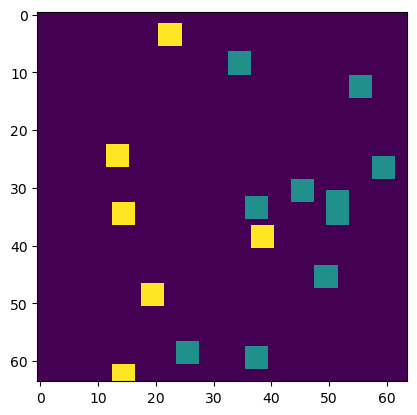

In [7]:
plt.imshow(wellfacies_test[55,0])

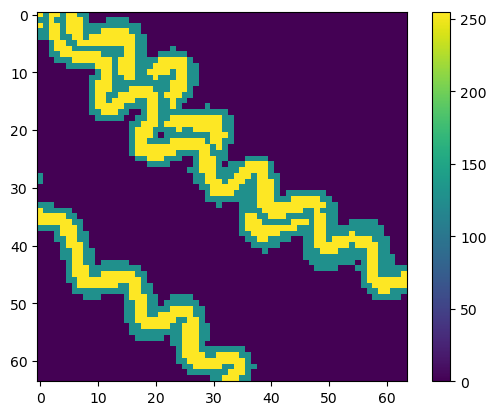

In [8]:
plt.imshow(image_test[60,0])
plt.colorbar()

#### Global features are kept and inputted into Networks with the scale of -1 to 1. To recover the global features into its original scales, use the below transformation functions.


In [9]:
#orit_test = (label_test[:,0]/2+0.5)*168-84
back_ratio_test = (label_test[:,0]/2+0.5)*0.8037109375+0.167724609375
width_test = (label_test[:,1]/2+0.5)*0.8+2.7
amwv_ratio_test = (label_test[:,2]/2+0.5)*0.4866197183098592+0.06338028169014084

### 2. Import pre-trained Network

In [10]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import networks.
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)

c:\Users\Windows\anaconda3\envs\gansim\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '



### 3. Evaluation of the imported pretrained Generator


### 3.1 Fetch 300 inputs from Test dataset

In [21]:
# Sample 300 global features, probability maps, and well facies data
faciesmodels_real = image_test[:3000]
labels_inspect = label_test[:3000]
proborder = np.arange(3000) * 8 + np.random.RandomState(32).randint(0, 8, size=3000)

wellfacies_inspect_init = wellfacies_test[proborder]
wellfacies_points_inspect = np.where(wellfacies_inspect_init>0, 1, 0)
wellfacies_facies_inspect = np.where(wellfacies_inspect_init<1.5, 0, 1)
wellfacies_inspect = np.concatenate([wellfacies_points_inspect, wellfacies_facies_inspect], 1)

In [22]:
print(labels_inspect.shape)
print(wellfacies_inspect.shape)

(3000, 3)
(3000, 2, 64, 64)


##### Create masks to only output visualize well facies against white background

In [23]:
### Enlarge areas of well points for displaying ###
wellfacies_onechannel = wellfacies_inspect[:,0:1]+wellfacies_inspect[:,1:2]
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

c:\Users\Windows\anaconda3\envs\gansim\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  """


### 3.2 General visual assessment

####  Visual assessment on realism, diversity, conditioning to global features, conditioning to well facies data

* (1) Input corresponding global features with well data into trained Generator

   Second column corresponds to ground truth for well facies data and global features.

In [19]:
print(Gs.input_shapes)

[[None, 128], [None, 1], [None, 2, 64, 64]]


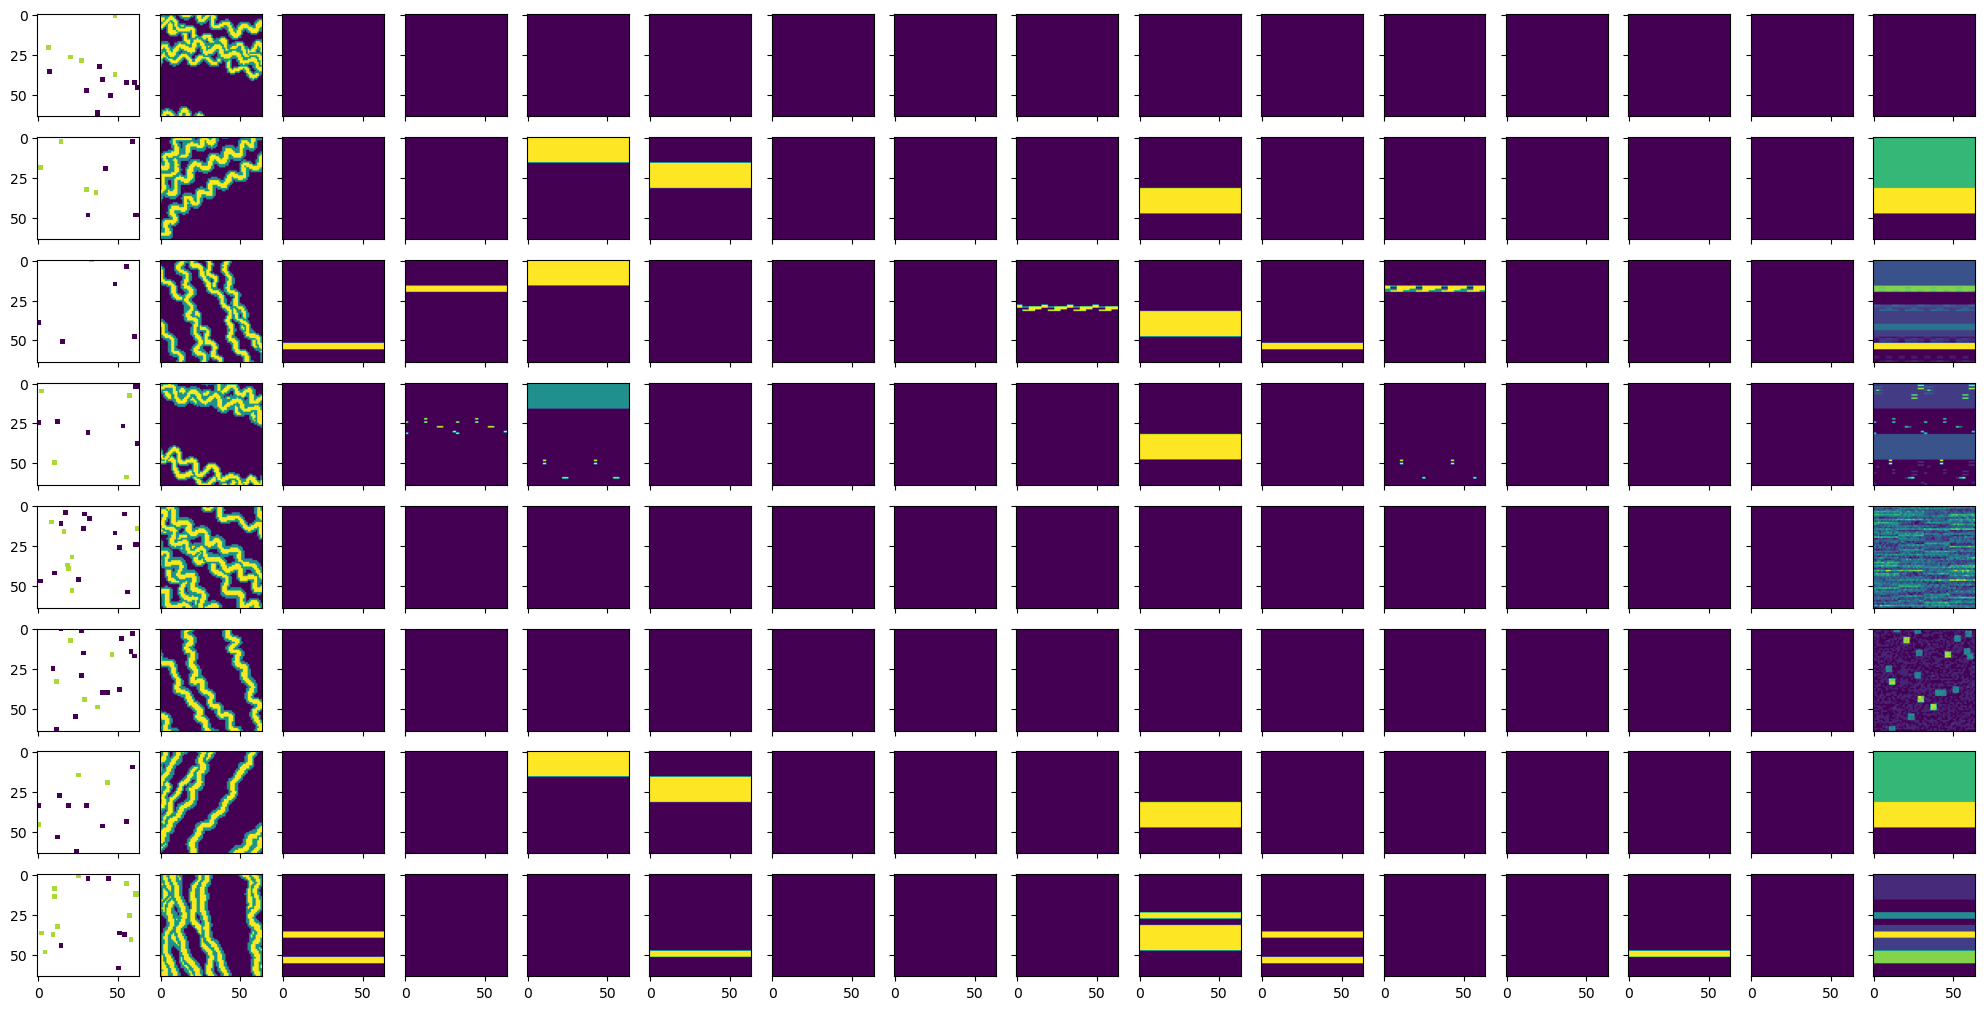

In [24]:
fig, ax = plt.subplots(8, 16, sharex='col', sharey='row')
fig.set_size_inches(25, 12.5, forward=True)

images_plt_average = np.zeros((8,1,64,64))
for i in range (8):
    
    ax[i, 0].imshow(wellfacies_onechannel_mask[i,0], cmap=cmap_well, vmax = 2.15)
    ax[i, 1].imshow(faciesmodels_real[i,0,:,:])  # *15+50 is to create inconsistency between labels and probimg
    
    latents_plt = np.random.randn(100, Gs.input_shapes[0][1])
    labels_plt = np.repeat(np.expand_dims(labels_inspect[i,0:1], axis=0), 100, axis=0)  ## 
    wellfacies_plt = np.repeat(np.expand_dims(wellfacies_inspect[i], axis=0), 100, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)

    images_plt_a = (np.where(images_plt> -0.2, 1, images_plt) + 1)/2
    images_plt_average[i] = np.average(images_plt_a, axis = 0)

    for j in range(2,15):
        ax[i, j].imshow(images_plt[j-2,0,:,:])
    ax[i, 15].imshow(images_plt_average[i, 0])    
#plt.savefig(network_dir + "Random Latents.png", dpi=200) 

* (2) Input random global features as: mud_ratio with in real mud_ratio +/- 0.1; sinuosity and width are totally randomized.

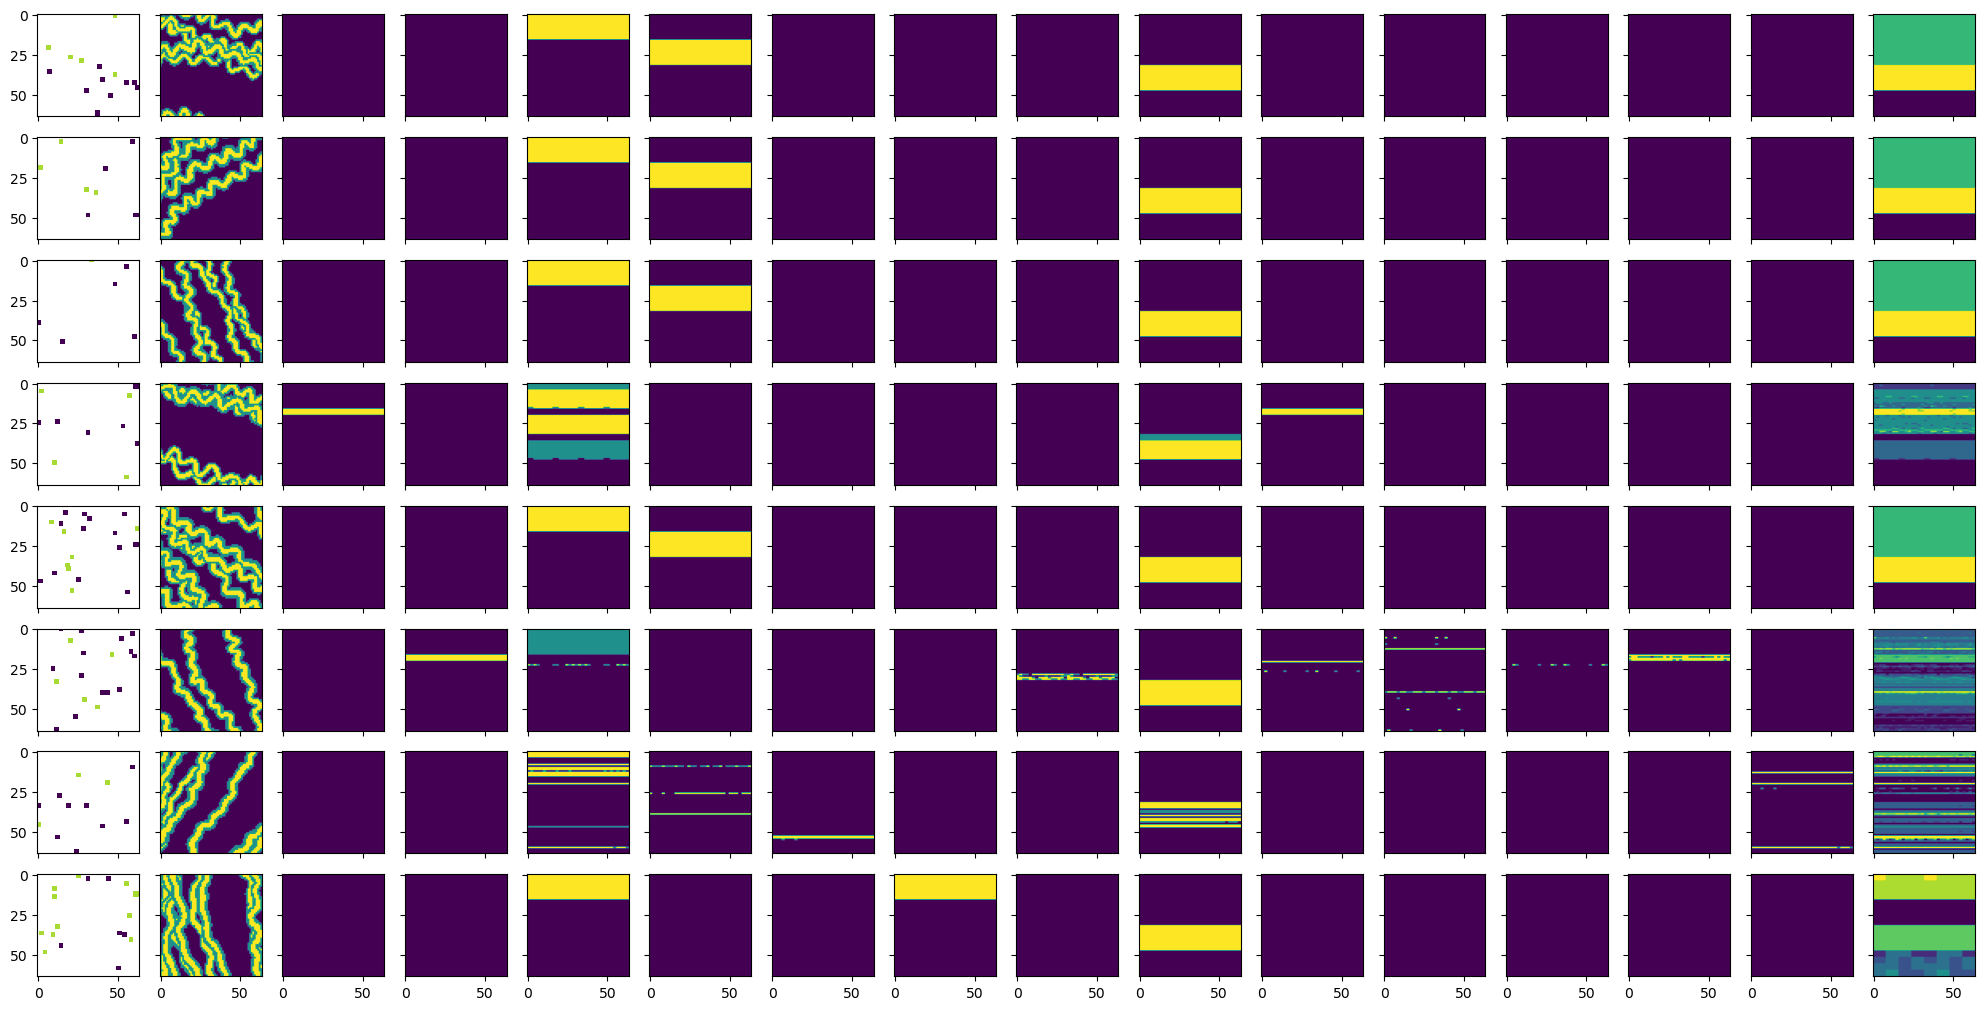

In [26]:
fig, ax = plt.subplots(8, 16, sharex='col', sharey='row')
fig.set_size_inches(25, 12.5, forward=True)

images_plt_average = np.zeros((8,1,64,64))
for i in range (8):
    
    ax[i, 0].imshow(wellfacies_onechannel_mask[i,0], cmap=cmap_well, vmax = 2.15)
    ax[i, 1].imshow(faciesmodels_real[i,0,:,:])  # *15+50 is to create inconsistency between labels and probimg
    
    latents_plt = np.random.randn(100, Gs.input_shapes[0][1])
    labels_plt = np.repeat(np.expand_dims(labels_inspect[i,0:1], axis=0), 100, axis=0)  
    labels_plt = labels_plt + np.random.uniform(low=-0.2, high=0.2, size=(100,1))    
    wellfacies_plt = np.repeat(np.expand_dims(wellfacies_inspect[i], axis=0), 100, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)

    images_plt_a = (np.where(images_plt> -0.2, 1, images_plt) + 1)/2
    images_plt_average[i] = np.average(images_plt_a, axis = 0)

    for j in range(2,15):
        ax[i, j].imshow(images_plt[j-2,0,:,:])
    ax[i, 15].imshow(images_plt_average[i, 0])    
#plt.savefig(network_dir + "Random Latents.png", dpi=200) 

### 3.3 Evaluation of Generator's conditioning ability to global features

#### 3.3.1 Visual assessment by comparing to corresponding ground truth facies models.

* (1) Sinuosity vs. mud facies ratio

      Generate facies models with increasing input sinuosity index and increasing input inter-channel mud facies ratio


**    Choose appropriate increasing global features from test data.  **
      These chosen global features will be used to simulate facies models; these facies models will be compared to ground truth facies models with the same global features in test dataset
      

In [27]:
back_ratio_no = 8
back_ratio_test_max = np.max(back_ratio_test)
back_ratio_test_min = np.min(back_ratio_test)

plot_img_no = np.empty((back_ratio_no), dtype = np.int)
for i in range (back_ratio_no):
        for r in range(back_ratio_test.shape[0]):          
            if back_ratio_test[r] > (back_ratio_test_max - back_ratio_test_min) * i/back_ratio_no+back_ratio_test_min and \
            back_ratio_test[r] < (back_ratio_test_max - back_ratio_test_min) * (i+1)/back_ratio_no+back_ratio_test_min and \
            width_test[r] >= 3 and width_test[r] <3.2: 
                plot_img_no[i] = r
                break

In [28]:
print(plot_img_no)

[237   4  17   1  13   9  14 647]


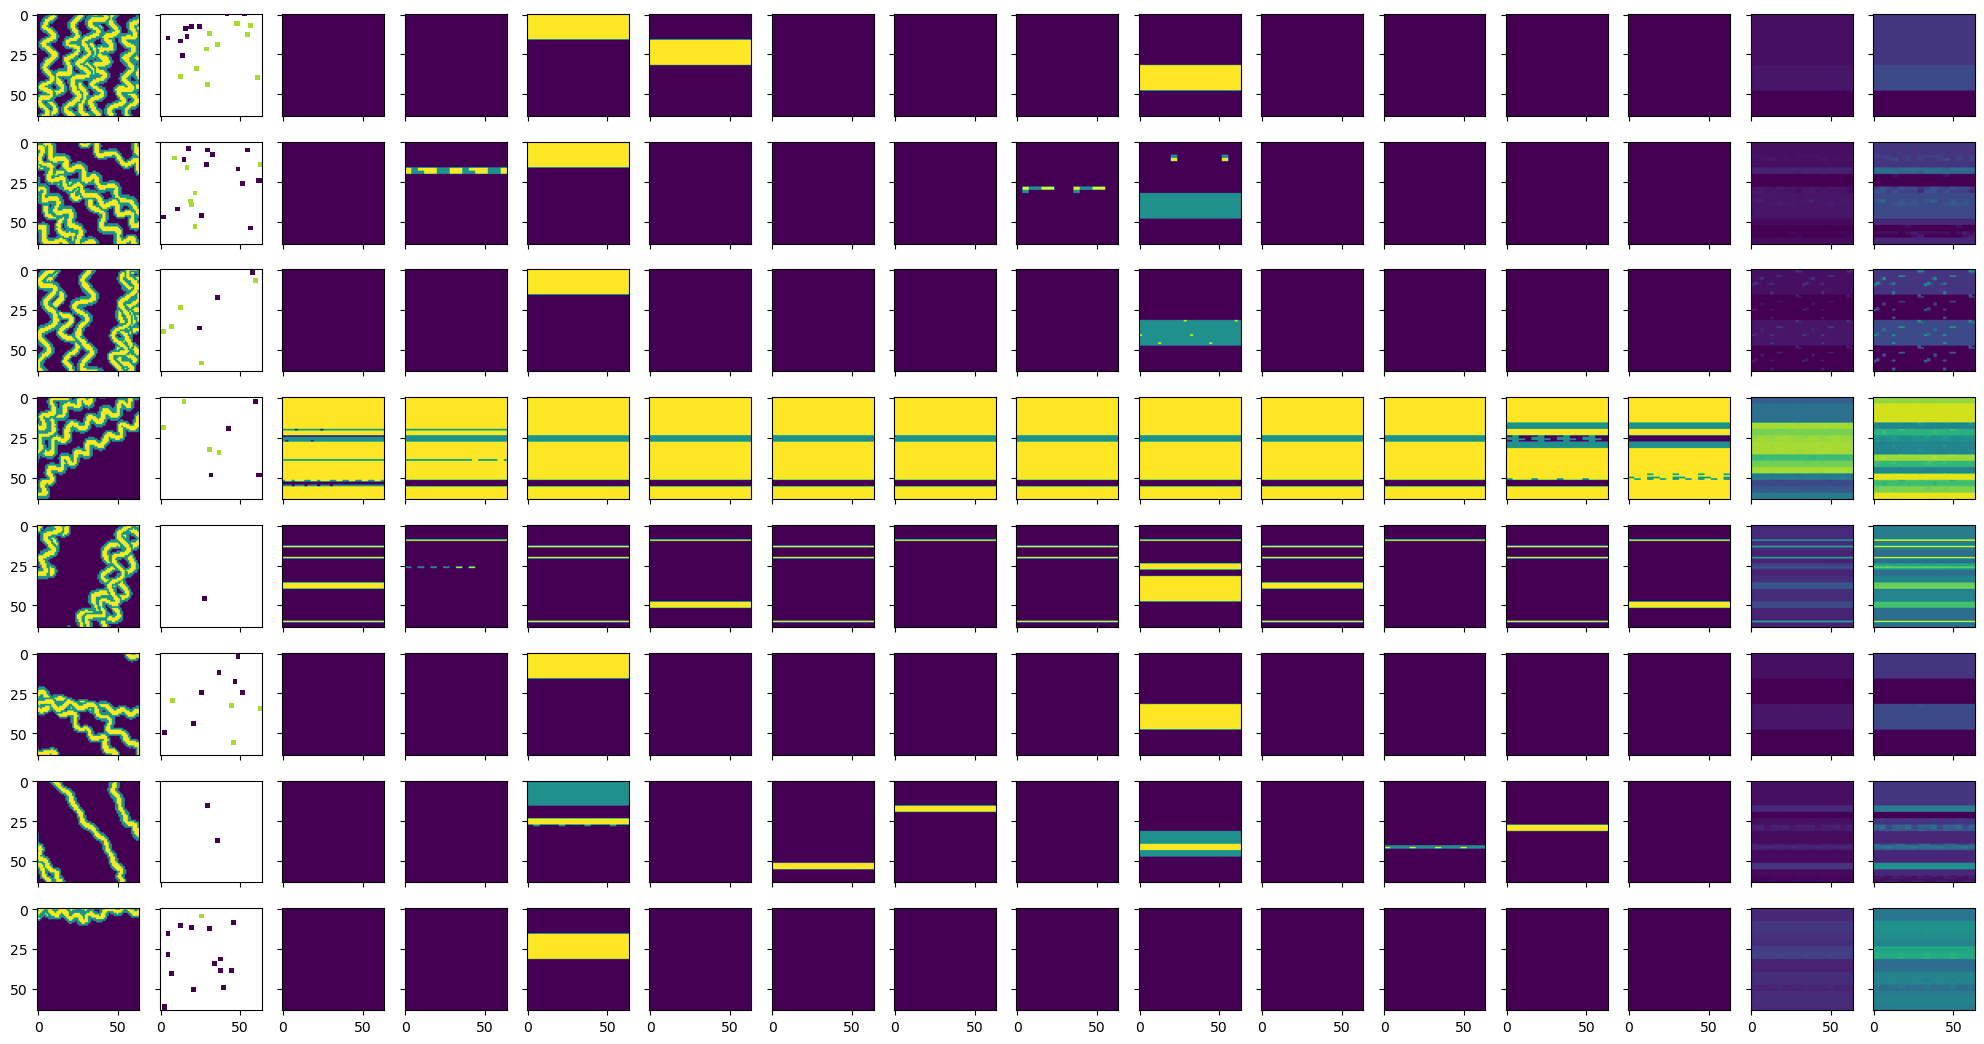

In [30]:
fig, ax = plt.subplots(8, 16, sharex='col', sharey='row')
fig.set_size_inches(25, 13, forward=True)

images_plt_average = np.zeros((8,1,64,64))
images_plt_variance = np.zeros((8,1,64,64))
for i in range (8):
    gt_no = plot_img_no[i]
    ax[i, 0].imshow(faciesmodels_real[gt_no,0,:,:])  # *15+50 is to create inconsistency between labels and probimg    
    ax[i, 1].imshow(wellfacies_onechannel_mask[gt_no,0], cmap=cmap_well, vmax = 2.15)
    
    latents_plt = np.random.randn(100, Gs.input_shapes[0][1])
    labels_plt = np.repeat(np.expand_dims(labels_inspect[gt_no,0:1], axis=0), 100, axis=0)  ## 
    wellfacies_plt = np.repeat(np.expand_dims(wellfacies_inspect[gt_no], axis=0), 100, axis=0)
    
    images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.3, 1, images_plt)
    images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)

    images_plt_a = np.where(images_plt> -0.3, 1, 0)
    
    images_plt_average[i] = np.average(images_plt_a, axis = 0)
    images_plt_variance[i] = np.var(images_plt_a, axis = 0)

    for j in range(2,14):
        ax[i, j].imshow(images_plt[j-2,0,:,:])
    ax[i, 14].imshow(images_plt_average[i, 0], vmin = 0, vmax = 1) 
    ax[i, 15].imshow(images_plt_variance[i, 0], vmin = 0, vmax = 0.25)
# plt.savefig(network_dir + "Condition to mud facies.png", dpi=200) 

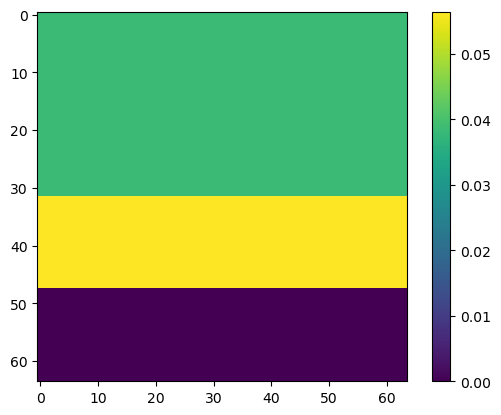

In [31]:
plt.imshow(images_plt_variance[0, 0])
plt.colorbar()
plt.savefig(network_dir + "variance colorbar.png", dpi=200) 

#### 3.3.2 Quantitative assessment by comparing to corresponding ground truth facies models.

####  (1) Assess inter-channel mud facies ratio

In [32]:
back_ratio_no = 100
# Generate latent vectors.
latents_plt = np.random.RandomState(61).randn(back_ratio_no, Gs.input_shapes[0][1]) 
labels_plt = label_test[:back_ratio_no, 0:1]
wellfacies_plt = wellfacies_inspect[:back_ratio_no]

# Run the generator to produce a set of images.
images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt)
images_plt = np.where(images_plt< -0.3, -1, images_plt)
images_plt = np.where(images_plt> 0.3, 1, images_plt)
images_plt = np.where((images_plt> -0.4) & (images_plt< 0.4), 0, images_plt)

test_fake_back_ratio = 1-np.count_nonzero(np.where(images_plt >=-0.5,1,0), (1,2,3))/(64*64)
test_real_back_ratio = back_ratio_test[:back_ratio_no]

y=-0.113931x+(1.032375)


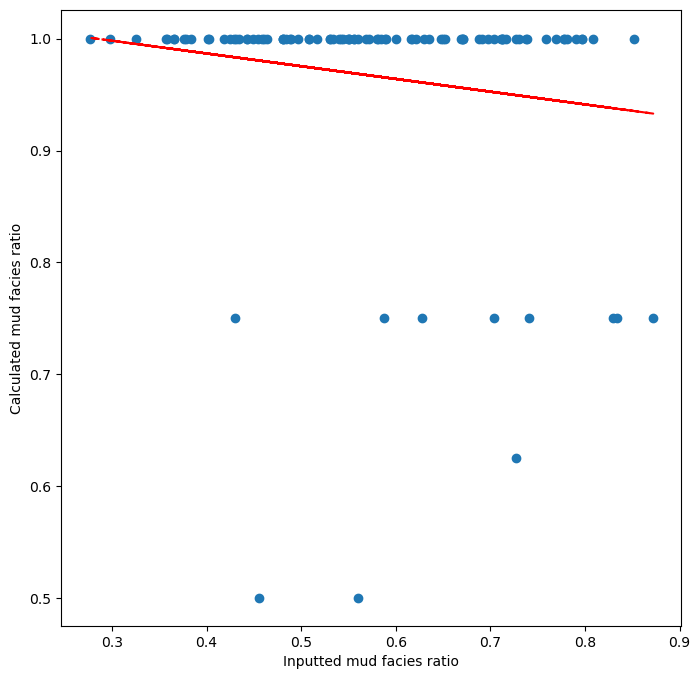

In [33]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8, forward=True)

ax.scatter(test_real_back_ratio, test_fake_back_ratio)
# calc the trendline
z = np.polyfit(test_real_back_ratio, test_fake_back_ratio, 1)
p = np.poly1d(z)
plt.plot(test_real_back_ratio,p(test_real_back_ratio),"r--")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

ax.set_xlabel("Inputted mud facies ratio")
ax.set_ylabel("Calculated mud facies ratio")
plt.savefig(network_dir +"Mud facies ratio scatter of fake vs real.png", dpi=200)   

In [34]:
np.savetxt(network_dir + 'inputted mud facies proportion.out', np.reshape(test_real_back_ratio,[-1,1]), delimiter='\n', fmt='%1.4e')   
np.savetxt(network_dir + 'Calculated mud facies proportion.out', np.reshape(test_fake_back_ratio,[-1,1]), delimiter=',', fmt='%1.4e')

### 3.4 Evaluation of Generator's conditioning ability to input well data

**Well points accuracy evaluation**

In [35]:
def get_random_well_facies_data(images_num):
    well_points = np.zeros([images_num, 1, 64, 64], dtype = int)
    for i in range(images_num):
        well_points_num = np.random.RandomState(3*i).choice(np.arange(8, 16), 1)  # Random choose the expected total number of well points
        xs = np.random.choice(64, well_points_num)
        ys = np.random.choice(64, well_points_num)
        well_points[i, 0, xs, ys] = 1

    # Using test facies models to sample faices types at well  points
    well_facies = np.where(well_points * image_test[:images_num]>0, 1, 0)
    well_facies = np.concatenate([well_points, well_facies], 1)      
 
    return well_facies

In [36]:
def generate_images(realization_num, well_facies):
    # Generate latent vectors.
    latents_plt = np.random.randn(realization_num, Gs.input_shapes[0][1]) 
    labels_plt =  np.random.uniform(-1, 1, (realization_num, Gs.input_shapes[1][1])) 
    well_facies_plt = well_facies

    # Run the generator to produce a set of images.
    images_plt = Gs.run(latents_plt, labels_plt, well_facies_plt)
    images_plt = np.where(images_plt< -0.3, -1, images_plt)
    images_plt = np.where(images_plt> 0.15, 1, images_plt)
    images_plt = np.where((images_plt>= -0.3) & (images_plt<= 0.15), 0, images_plt)
    return images_plt

In [37]:
def well_points_accuracy(well_facies, fake_imgs_a):
    gg = well_facies_smp_train_facies[:,0:1] + well_facies_smp_train_facies[:,1:2]
    
    recognized_f1 = np.where((gg==2) & (well_facies_smp_train_facies[:,0:1] * (fake_imgs_a+1) > 0.8), 1, 0)
    f1_prob = np.sum(recognized_f1)/np.sum(np.where(gg==2,1,0))

    recognized_f0 = np.where((gg==1) & (well_facies_smp_train_facies[:,0:1] * (fake_imgs_a+2) ==1), 1, 0)
    f0_prob = np.sum(recognized_f0)/np.sum(np.where(gg==1,1,0))
    
    return f1_prob, f0_prob

In [38]:
def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,4,4], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

In [40]:
images_num = 100
well_facies_smp_train_facies = get_random_well_facies_data(images_num)
well_facies_smp_train_facies_el = enlarge(well_facies_smp_train_facies)      
fake_imgs = generate_images(images_num, well_facies_smp_train_facies_el)
f_c_prob, f_m_prob = well_points_accuracy(well_facies_smp_train_facies, fake_imgs)
print(f_c_prob) # well facies reproduction accuracy for input channel complex facies
print(f_m_prob) # well facies reproduction accuracy for input mud facies

0.028747433264887063
0.9566517189835575


###  4. Evaluation of the imported pretrained Discriminator as a global feature recognizer

#### Assess D with Test data

In [41]:
plt_data_no = 100
a = np.arange(plt_data_no)
np.random.shuffle(a)
test_img_no = a[:plt_data_no]
_, features = D.run(image_test[test_img_no]/127.5-1)

y=0.000011x+(0.844116)


Text(0, 0.5, 'Predicted mud facies ratio by D')

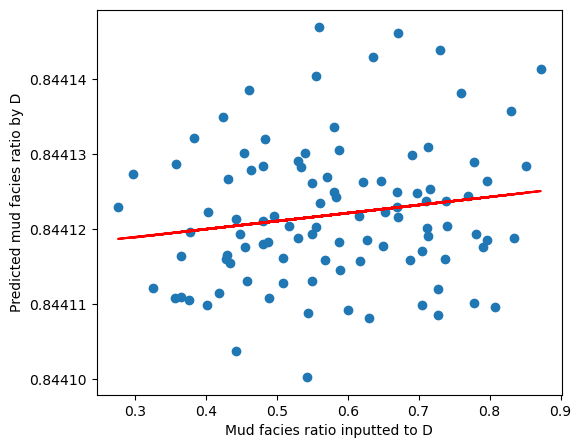

In [42]:
# orit_test = (label_test[:,0]/2+0.5)*168-84
# back_ratio_test = (label_test[:,1]/2+0.5)*0.8037109375+0.167724609375
# width_test = (label_test[:,2]/2+0.5)*0.8+2.7
# amwv_ratio_test = (label_test[:,3]/2+0.5)*0.4866197183098592+0.06338028169014084

features[:, 0] = (features[:, 0] / 2 + 0.5) *0.8037109375+0.167724609375

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 5, forward=True)

# (back_ratio[test_image_num], width[test_image_num], amwv_ratio[test_image_num]) 
# labels_cor includes: orientation, background_ratio, width, amplitude/wavelength ratio, after shifting to (-1, 1)
ax.scatter(back_ratio_test[test_img_no], features[:, 0]) 
# calc the trendline
z1 = np.polyfit(back_ratio_test[test_img_no], features[:, 0], 1)
p1 = np.poly1d(z1)
ax.plot(back_ratio_test[test_img_no],p1(back_ratio_test[test_img_no]),"r-")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z1[0],z1[1]))
ax.set_xlabel("Mud facies ratio inputted to D")
ax.set_ylabel("Predicted mud facies ratio by D")


#### Assess D with Simulated data
*(1) Randomly Select global features data

In [43]:
print(plt_data_no)

100


In [44]:
# Generate latent vectors.
latents_plt = np.random.randn(plt_data_no, Gs.input_shapes[0][1]) # 1000 random latents *Gs.input_shapes[0][1:]=[None, 128] [None, 4]

labels_plt = labels_inspect[:plt_data_no,0:1]

wellfacies_plt = wellfacies_inspect[:plt_data_no]

# Run the generator to produce a set of images.
images_plt = Gs.run(latents_plt, labels_plt, wellfacies_plt)
images_plt = np.where(images_plt< -0.7, -1, images_plt)
images_plt = np.where(images_plt> 0.3, 1, images_plt)

_, features = D.run(images_plt)


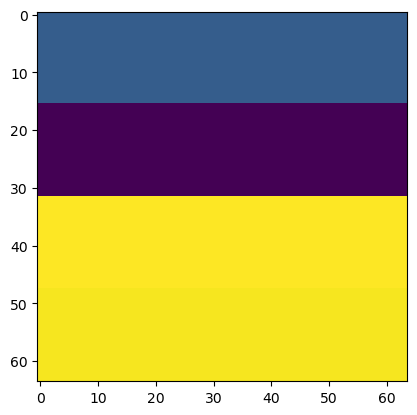

In [45]:
plt.imshow(images_plt[0,0])

y=0.000011x+(0.844116)


Text(0, 0.5, 'Predicted mud facies ratio by D')

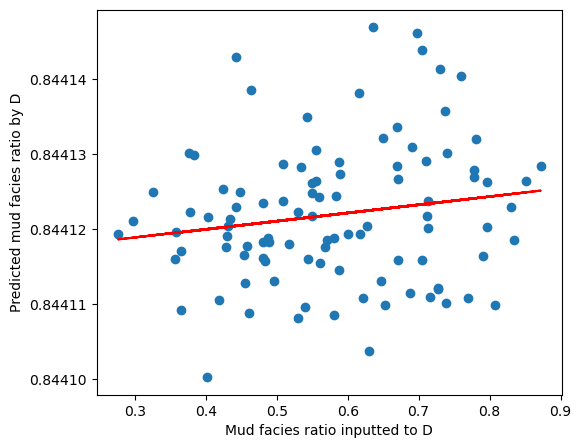

In [46]:
features[:, 0] = (features[:, 0] / 2 + 0.5) *0.8037109375+0.167724609375
labels_plt[:, 0] = (labels_plt[:, 0] / 2 + 0.5) *0.8037109375+0.167724609375

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 5, forward=True)

# labels_cor includes: orientation, background_ratio, width, amplitude/wavelength ratio, after shifting to (-1, 1)
ax.scatter(labels_plt[:, 0], features[:, 0]) 
# calc the trendline
z1 = np.polyfit(labels_plt[:, 0], features[:, 0], 1)
p1 = np.poly1d(z1)
ax.plot(labels_plt[:, 0],p1(labels_plt[:, 0]),"r-")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z1[0],z1[1]))
ax.set_xlabel("Mud facies ratio inputted to D")
ax.set_ylabel("Predicted mud facies ratio by D")
